In [1]:
import itertools
from itertools import combinations
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pymc as pm
from scipy.special import expit, logit
import pytensor.tensor as pt
from pymc.distributions.transforms import Ordered

from collections import Counter
from tqdm import tqdm
import pickle
import random
import itertools
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# versions

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==2.2.0
numpy==1.26.4
seaborn==0.13.2
arviz==0.17.0
pymc==5.10.3


# Introduction

This notebook runs the tests for the focus questions of the study. We preregistered these questions, along with what we expect to find and how we are trying to answer them. We first use simulated data to try out these tests.

These are the questions/hypotheses that we preregistered. For all of these, we will report the distributions rather than the outcome of a binary hypothesis test (as there are no immediate use-cases that allow us to determine a ROPE and appropriate HDI that are required for such a binary test).

1) **How strong is the variation between raters' judgements of societal relevance?**

<u>Expectations:</u> There is substantial variation between raters' judgements of the societal relevance of papers.

<u>Methods:</u>

    1.1) *Use the model to get posterior predictive samples from new raters and paper sets to estimate the effect size of rater characeristics (chauvinism and strictness).* More precisely, we will estimate how much we should expect the proportion of 1s (for strictness and chauvinism) and the mean rank score (for chauvinism) to change when you change from one random rater to another.

    1.2) *Compare the effect size of the rater characeristics (strictness and chauvinism) with that of fields.* More precisely, we look at the differences between the effect sizes of fields (i.e. switching from one field to another), chauvinism (switching from one rater to another) and strictness (switching from one rater to another). If the difference between effect sizes for a pair centers around zero, we have no strong reason to think they are different. If they are clearly positive or negative, one is clearly bigger than the other.


2) **Are there differences between fields?**

<u>Expectations:</u> There are differences between fields. More precisely, we expect fields that clearly higher proportions of the content codes (such as ethics, empirical, health and wellbeing) to score higher than fields that have a lower proportion of papers on these topics.

<u>Methods:</u> 

    2.0) *Compare the expected proportion of 1s of all the fields.* We will draw posterior predictive samples from many trials with randomly drawn raters and papers, and assume they are from each of the five fields in turn. We then compare how the expected proportion of papers deemed societally relevant changes between these. This gives us a direct comparison between each of the fields, as well as a ranking of fields in terms of expected proportions of papers deemed societally relevant.


3) **Are raters chauvinistic?**

<u>Expectations:</u> We expect that raters will value papers from their own field higher, either because they are biased or because they understand these papers better than other raters.

<u>Methods:</u> 

    3.0) *Compare the expected proportion of 1s of trials including chauvinism with trials excluding chauvinism.* We will draw posterior predictive samples from many trials with randomly drawn raters and papers, both with and without chauvinism included in the linear model. We then compare how the expected proportion of papers deemed societally relevant changes between these. This gives us a direct estimate of the difference chauvinism makes, and whether it indeed increases the numbers of papers deemed societally relevant by the raters. Note that this is different from looking at the expected difference between two random raters (in that test used in 1.1 and 1.2 the chauvinism parameter is always included in the model).

4) **What is the aggregate judgement on the societal relevance?**

<u>Expectations:</u> Based on previous studies and our own experiences with our own humanities fields, we expect the aggregate judgement to be below 50%. 

<u>Methods:</u> 

    4.0) *Determine the expected proportion of 1s of trials with chauvinism excluded from the linear model.* We will draw posterior predictive samples from the model without chauvinism. We exclude chauvinism because for this test we are interested in the 'true relevance', i.e. without a biasing factor like chauvinism. We could exclude strictness as well, but this doesn't really make conceptual sense (you can select raters from another field to exclude chauvinism, but any hypothetical rater will still have their own strictness) and it would assume that all raters are well calibrated on a single threshold of funding for the ideal committee. So, we include it but sample from thousands of different raters to make sure that any extremes are washed out.

# Data

## Simulated data

In [67]:
### simulate new data

np.random.seed(2028)

## experiment setup
K = 5 # number of items being ranked
J = 10 # number of raters
B = 69 # number of sets of five abstracts

## true values

field_params = np.array([0.8,1,0,-0.2,-1.1])
field_values = np.tile(field_params, (B,1)) # for simulating


paper_intercepts = np.random.normal(0,0.5,(B,K))

content_params = np.array([0.4,0.9,-0.3,0.8,0,1,1.3]) 
content_presence = np.random.choice([0, 1], size=(B, K, len(content_params)), p=[0.8, 0.2]) 
content_values = np.sum(content_presence * content_params, axis=2) # for simulating
C = len(content_params)

true_paper_values = paper_intercepts + content_values + field_values # sum field and content values to get the paper value

field_codes = np.random.randint(0,K,J) # raters are from one of the included fields
chauvinism_m = 1.5
chauvinism_s = 0.4
rater_chauv = np.random.normal(chauvinism_m, chauvinism_s, (1,J,1))

# chauvinism affects the ratings, so create an array of zeros apart form the papers where the rater field matches the paper field
chauv_array = np.zeros((B, J, K), dtype=int)
for i in range(J):
    chauv_array[:, i, field_codes[i]] = 1
chauv_true = chauv_array * rater_chauv # for simulating

strictness_m = 0
strictness_s = 0.3
strictness_params = np.random.normal(strictness_m, strictness_s, (1,J,1))


# difference in accuracy between raters (the latent estimate has the linear model as mean and this as the sd)
raters_sigma = np.random.uniform(0.05,0.3,(1,J,1))

## generate the data

# create the ranking data
real_paper_ranks = np.argsort(true_paper_values, axis = 1) # the true rankings per set, in case we need them
ratings_true = np.tile(true_paper_values[:, np.newaxis, :], (1, J, 1)) # array with for each rater for each paper the true paper values

# add noise and chauvinism to the true values. This is what determines the raters' ranking.
ratings = np.random.normal(ratings_true + chauv_true, raters_sigma) # simulate the estimated scores on the latent scale
rank_data = np.argsort(ratings, axis=2) # the ranked sets as we get them from raters

# create the binary data
ratings_strictness = ratings + strictness_params # estimated paper value (used for rank data) combined with strictness
transformed_ratings_strictness = expit(ratings_strictness) # inverse logit function to transform the values to a probability



true_values = {"fields":field_params,
              "content":content_params,
              "chauv_mean":chauvinism_m,
               "chauv_sd": chauvinism_s,
              "chauvinism":rater_chauv,
              "sigma":raters_sigma.mean(),
              "strictness_mean":strictness_m,
               "strictness_sd":strictness_s,
              "strictness":strictness_params,
              "paper_ranks":real_paper_ranks,
              "paper_values":true_paper_values,
              "paper_intercepts":paper_intercepts}

## for indexing in the model
## The indexing is a bit tricky because of all the 3D arrays. At some point we could use coords in pm.

# fields idx
fields_presence = np.tile(np.arange(K), (B, 1))

# content parameters idx
content_presence = content_presence.reshape(B*K,len(content_params))

# original order of the observed rank data, needed to get them back into that order for the binary scoring
rank_data_argsort = np.argsort(rank_data, axis=2) 

# the observed rank data as it goes into the model
rank_data = np.argsort(ratings, axis=2)

# Observed binary data
binary_data = np.random.binomial(1, p = transformed_ratings_strictness)

# chauvinism idx
chauv_array = np.zeros((B, J, K), dtype=int)
for i in range(J):
    chauv_array[:, i, field_codes[i]] = 1


## Pilot data

In [73]:
## have to clean this up at some point!!

df = pd.read_csv('...\IIH_all_data.csv')
df = df.drop(['Unnamed: 0'], axis=1)

# Pilot study had two groups, select here which group

df = df.loc[df.group == 'group2']

# put in the order that the model assumes they are in
df = df.sort_values(by = ['block','field','rater'])

# dtype should be categorical

cat_cols = ['block', 'field', 'rater', 'binary', 'abstract','ordinal', 
            'rater_disc', 'doctype', 'group','chauvinism']

df[cat_cols] = df[cat_cols].astype('category')

## Indices for data on the rating-level (i.e. each row is a rating)

block_idx = df.block.cat.codes.values
field_idx = df.field.cat.codes.values
rater_idx = df.rater.cat.codes.values
binary_idx = df.binary.cat.codes.values
abstract_idx = df.abstract.cat.codes.values
chauvinism_idx = df.chauvinism.cat.codes.values

# The categories of these variables
block_codes = df.block.cat.categories.values
field_codes = df.field.cat.categories.values
rater_codes = df.rater.cat.categories.values
abstract_codes = df.abstract.cat.categories.values
chauvinism_codes = df.chauvinism.cat.categories.values

K = len(field_codes)
B = len(block_codes)
J = len(rater_codes)


random_rater = df['rater'].values[0]
df_short = df.loc[(df.rater == random_rater)].copy()
causes_data = df_short[['Present','Intolerance','Ethics','Empirical','Environment','Education','Wellbeing']].values
C = causes_data.shape[1]

scores = (df[['block','ordinal','field','rater','binary']].pivot(
    index=['block','rater'], 
    columns=['field'], 
    values=['ordinal','binary'])[['ordinal','binary']].reset_index())

rank_data = scores['ordinal'].values.reshape(B,J,K).astype('int')
binary_data = scores['binary'].values.reshape(B,J,K).astype('int')
rank_data_argsort = np.argsort(rank_data, axis=2) # array with the indices that would sort the true data. we need this in the model to enforce the ranking.
raterfield_codes = np.array([3,4,0,0,2,1,1])  #group1: [3,3,3,4,0,0,2,1,1]

chauv_array = np.zeros((B, J, K), dtype=int)
for i in range(J):
    chauv_array[:, i, raterfield_codes[i]] = 1

index_array = np.arange(B)[:, np.newaxis, np.newaxis] * np.ones((B, J, K)).astype(int) # array to force the ranking on a 3D array in the model, used together with rank_data_argsort for indexing. there should be a more elegant way of doing this...
chauv_array2 = np.take_along_axis(chauv_array, rank_data_argsort, axis = -1) # array to put the paper estimated back in the old order (after the model sorts them to estimate their value)

# we need an array to bring the estimates (latent) back to the order of the data after sorting them
sorting_array = np.argsort(rank_data_argsort, axis = 2)

# we need an array to index which rating is by which rater
rater_idx = np.tile(np.arange(J), (B, K, 1)).transpose(0, 2, 1).reshape(B * J * K)
content_params = ['Present', 'Intolerance', 'Ethics','Empirical', 'Environment', 'Education', 'Wellbeing']

content_presence = causes_data.reshape(B,K,len(content_params))
field_presence = np.eye(K)[None, :, :] * np.ones((B, 1, 1))
content_presence2 = content_presence.reshape(B*K,len(content_params))
array = np.tile(np.arange(K), (B, 1))


# The model

see the simuls notebook for more information on this model.

In [5]:
with pm.Model() as model9:

    # data
    CONTENT = pm.MutableData('CONTENT', content_presence)
    
    content = pm.Normal('content',0,1,shape = (len(content_params)))
    dot_prod = pt.dot(content_presence, content)
    dot_prod_reshaped = dot_prod.reshape((B,K))

    fields_mean = pm.Normal('fields_mean', 0, 1)
    fields_sd = pm.Uniform('fields_sd', 0.01, 2)
    
    fields = pm.Normal('fields',0, fields_sd,shape = (K))

    paper_intercepts = pm.Normal('paper_intercepts',0,1, shape = (B,K))
    paper_values = pm.Deterministic('paper_values', paper_intercepts + fields[fields_presence]+ dot_prod_reshaped )

    chauv_mean = pm.Normal('chauv_mean', 0, 1)
    chauv_sd = pm.Uniform('chauv_sd', 0.01, 2)
    
    # Non-centered parameterization for chauvinism
    chauvinism_offset = pm.Normal('chauvinism_offset', 0, 1, shape=(1, J, 1))
    chauvinism = pm.Deterministic('chauvinism', chauv_mean + chauv_sd * chauvinism_offset)

    mu = pm.Deterministic('mu', pt.tile(paper_values[:,pt.newaxis,:],(1,J,1)) + (chauv_array * chauvinism))

    reordered_mu = pm.Deterministic('reordered_mu', pt.take_along_axis(mu, rank_data, axis = -1))
    
    sigma = pm.Uniform('sigma',0.01,2)
    
    latent = pm.Normal('latent',
                       mu=reordered_mu,
                       sigma=sigma, 
                       transform=Ordered(), 
                       shape=(B,J,K),
                       # have to set test value to avoid issues with negative numbers
                       testval=np.tile(np.tile(np.arange(K), (B, 1))[:, np.newaxis, :], (1, J, 1))) 

    latent_reshaped = pt.take_along_axis(latent, rank_data_argsort, axis = -1)


    strictness_mean = pm.Normal('strictness_mean',0,1)
    strictness_sd = pm.Uniform('strictness_sd', 0.01, 2)
    
    # Non-centered parameterization for strictness
    strictness_offset = pm.Normal('strictness_offset', 0, 1, shape=(1, J, 1))
    strictness = pm.Deterministic('strictness', strictness_mean + strictness_sd * strictness_offset)

    binary = pm.Bernoulli('binary',logit_p = latent_reshaped + strictness, observed = binary_data)


In [9]:
## the model results

trace_test = az.from_netcdf("...\Trace9Simuls.nc")


# Use posterior predictive samples to calculate effect sizes

These posterior predictive samples are used in all the tests, so we calculate them first.

In [299]:
# a few variables shared between the different hypothesis tests

n_ppc = (69)*5
new_J = 20
colors = ["skyblue","lightgreen","orange","purple","darkred"]
n_trials = 1000

## Field effect size

First, we get estimates of how much each of the code causes occurs in each field. This we can then use to get posterior predictive samples from our main model. It is necessary to first estimate how often the various content codes occur in each of the fields, because this may be a reason why there are differences between fields but would not be captured by the fields parameter. Because certain content combinations occur more than others, we don't simply use cause per field, but 'combination of all causes' per field.

In [6]:
# note: if there is only one group, no need to combine and use 'df_short' instead of 'df_shortall' (which will be the case for the follow-up study)

# this is the pilot data on how often each code occured in each field
df_shortall = pd.read_csv('...\IIH_all_data.csv')
df_shortall = df_shortall.drop(['Unnamed: 0'], axis=1)

causes = ['Present','Intolerance','Ethics','Empirical','Environment','Education','Wellbeing']

# limit to one rater for each group, as all we need is the frequency of codes per paper

df_shortall = df_shortall.loc[df_shortall.rater.isin([521,342])]

# make column with code combo as value

df_shortall['array'] = [str(df_shortall[causes].iloc[i,:].values) for i in range(len(df_shortall))]

# limit to the columns of code-combos and field
causes_freq = df_shortall[['array','field']].copy()
causes_freq = causes_freq.astype('string')

# combine field and code combo, as we need to model the frequency of combinations per field 
causes_freq['combined'] = causes_freq['field'] + '_' + (causes_freq["array"])

# one hot encode and stack
causes_freq = pd.get_dummies(data = causes_freq, columns = ['combined'], dtype = int)
causes_freq = causes_freq.iloc[:,2:].stack().reset_index()
causes_freq['level_1'] = causes_freq['level_1'].astype('category')
causes_freq.rename(columns = {0:'observed','level_1':'field_cause_combo'}, inplace = True)

# get categories for the model
group_codes = causes_freq['field_cause_combo'].cat.categories.values
coords = {'g_n': group_codes }

# model the frequencies of the code combos

with pm.Model(coords=coords) as m_causes:
    
    GROUP = pm.MutableData('GROUP',causes_freq['field_cause_combo'].cat.codes.values)
    
    p = pm.Normal('p',0,5, dims = 'g_n')
    y = pm.Bernoulli('y', logit_p = p[GROUP], observed = causes_freq['observed'].values)

In [ ]:
# with m_causes:
#     trace_causes = pm.sample(500,tune = 500, chains = 2)

In [7]:
# trace_causes.to_netcdf("...\trace_causes.nc")
trace_causes = az.from_netcdf("...\trace_causes.nc")

In [12]:
# get the posteriors for each of the code-combos for each of the fields

code_counts = [trace_causes.posterior['g_n'].values[i].split('_')[1] for i in range(len(trace_causes.posterior['g_n'].values))]

# count the number of code-combinations per field, and use that to get the right group of posteriors for each field

h_c = code_counts.count('HIST')
l_c = code_counts.count('LING')
lit_c = code_counts.count('LIT')
p_c = code_counts.count('PHIL')
r_c = code_counts.count('REL')

trace_hist = az.extract_dataset(trace_causes.posterior['p'][:,:,:h_c], combined = True)
trace_ling = az.extract_dataset(trace_causes.posterior['p'][:,:,h_c:h_c+l_c], combined = True)
trace_lit = az.extract_dataset(trace_causes.posterior['p'][:,:,h_c+l_c:h_c+l_c+lit_c], combined = True)
trace_phil = az.extract_dataset(trace_causes.posterior['p'][:,:,h_c+l_c+lit_c:h_c+l_c+lit_c+p_c], combined = True)
trace_rel = az.extract_dataset(trace_causes.posterior['p'][:,:,len(code_counts) - r_c:], combined = True)

traces = [trace_hist, trace_ling, trace_lit, trace_phil, trace_rel]



# samples values from the posteriors of the causes parameters (causes params has all non-field causes)

causes_params = az.extract_dataset(trace_test.posterior['content'],  combined = True)['content'][:, np.random.randint(0,trace_test.posterior['content'].shape[1], size = n_ppc)]
# fieldsigma_params = az.extract_dataset(trace_test.posterior['field_sigma'], combined = True)['field_sigma'].values

# loop over the fields, and get values for each field, combining:
# 1) the parameter for that field
# 2) the probabilities of getting certain codes-combos
# 3) the parameters for the causes (multiplied by the code combo)
# then just make the sum of the linear model: sum all causes with the field

ppc_fields = {} # dict with for each field arrays of 1s and 0s that are the ppc samples.
causes_fields = {} # dict with the causes-arrays by field

for i in range(5):

    
    causes_probs = expit(traces[i]['p'][:, np.random.randint(0,traces[i]['p'].shape[1], size=n_ppc)])*5

    # make sure they sum to 1
    causes_probs = causes_probs / causes_probs.sum(axis = 0)
    
    # get code combos for that field
    
    dct = {}
    n_codes = len(traces[i]['g_n'].values)
    for j in range(n_codes):
        
        # this unelegant splitting operation is to turn the string-combo of codes back into an array of 1s and 0s for the causes
        dct[j] = np.array(list(map(int,traces[i]['g_n'].values[j].split('_')[2].split('[')[1].split(']')[0].split('.')[:-1]))) 
        
    # now get an array of the sampled code-combos for that field

    code_combos = [np.random.choice(np.arange(n_codes), p = k) for k in causes_probs.values.T]
    causes_data = np.array([dct[l] for l in code_combos])
    causes_fields[[f"field_{j}" for j in range(5)][i]] = causes_data

The plot below shows that in particular linguistics (high empirical, education, and present) and philosophy (high ethics and environment) should score relatively well. That is, of course, assuming that these contents increase the likelihood of a paper being societally relevant.

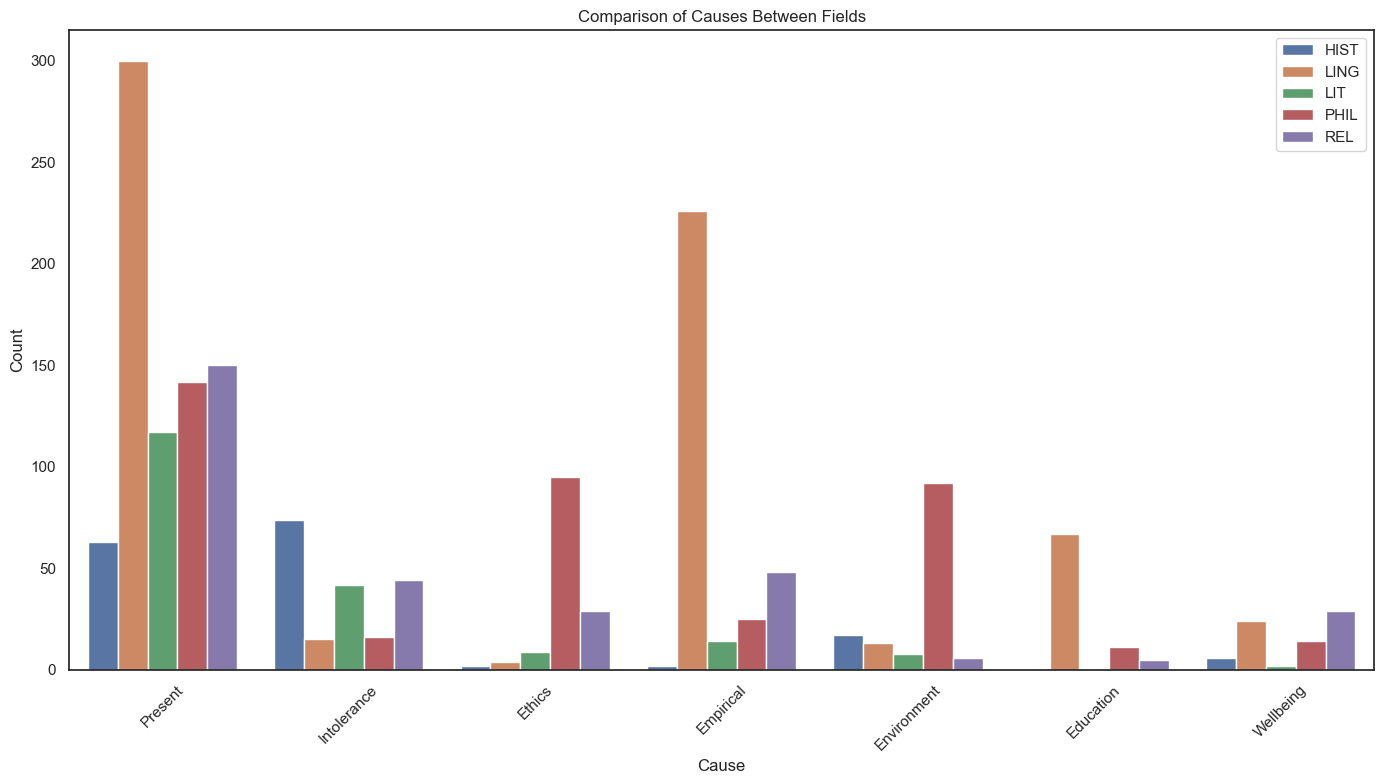

In [302]:
# plot the counts of cause combinations

summed_counts = {key: value.sum(axis=0) for key, value in causes_fields.items()}
causes_counts = pd.DataFrame.from_dict(summed_counts, orient='index',
                                       columns=['Present', 'Intolerance', 'Ethics', 'Empirical', 'Environment', 'Education', 'Wellbeing'])
causes_counts.index =  ['HIST',	'LING',	'LIT'	,'PHIL'	,'REL']
# Melt the DataFrame to long-form
df_long = causes_counts.reset_index().melt(id_vars='index', var_name='Cause', value_name='Count')

# Plotting with seaborn
plt.figure(figsize=(14, 8))
sns.barplot(data=df_long, x='Cause', y='Count', hue='index')
legend = plt.legend(facecolor='white')
plt.title('Comparison of Causes Between Fields')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Now that we have posterior predictive samples for content-codes by field, we can use these to get posterior predictive samples of binary data too, using the posteriors from our main model. Getting rank data doesn't make sense, as all papers in each trial would be from the same field.

In [110]:


field_names = ['HIST',	'LING',	'LIT'	,'PHIL'	,'REL']
trials = {field_names[i]:[] for i in range(K)}
paper_values_dct = {field_names[i]:[] for i in range(K)}

# I should probaby vecotrize this, very slow to do this in a loop.
# run n_trials trials with each time n_ppc new papers and new_J new raters
# when we run this for the real data, make sure that the order of fields in the two models is the same!!
for trial in tqdm(range(n_trials)):

    new_chauv = np.random.binomial(1, 0.2, new_J*n_ppc)

    chauvinism = np.random.normal(np.random.choice(np.ravel(trace_test.posterior['chauv_mean'].values), new_J, replace = True ),
                                 np.random.choice(np.ravel(trace_test.posterior['chauv_sd'].values), new_J, replace = True ))
    
    strictness = np.random.normal(np.random.choice(np.ravel(trace_test.posterior['strictness_mean'].values), new_J, replace = True ),
                                 np.random.choice(np.ravel(trace_test.posterior['strictness_sd'].values), new_J, replace = True ))
    
    paper_intercepts = np.random.choice(np.ravel(trace_test.posterior['paper_intercepts'].values), 
                                        (n_ppc), replace = True)
    
    sigma = np.random.choice(np.ravel(trace_test.posterior['sigma'].values), (new_J), replace = True)
    
    content = np.array([np.random.choice(az.extract_dataset(trace_test.posterior['content'])['content'].values[i,:], n_ppc) for i in range(len(content_params))])
        
    content_data = np.array(list(causes_fields.values()))
    
    

    # for each of the trials, set the field to one of our fields in turn, and record the proportion of 1s
    for i in range(K):
        fields = np.array([np.random.choice(az.extract_dataset(trace_test.posterior['fields'])['fields'].values[i,:], n_ppc) for i in range(K)])
        paper_values = paper_intercepts + ((content_data[i,:,:] * content.T).sum(axis = 1)) + fields[i]
        latent = np.random.normal(np.repeat(paper_values, new_J) + (np.tile(chauvinism, n_ppc) * new_chauv), np.tile(sigma, n_ppc))
        p = expit(latent + np.tile(strictness, n_ppc))
        outcome = np.random.binomial(1,p)
        trials[field_names[i]].append(outcome.mean())
        paper_values_dct[field_names[i]].append(paper_values)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:28<00:00, 11.25it/s]


# Chauvinism effect size

There are multiple ways of doing this:

- check the difference in 1s and 0s for chauvinism on and off.
    - Downside: this may hide how some raters are very chauvinism and some are not if they cancel each other out.
    - Upside: this gives an idea of the overall direction chauvinism pushes in, and how strong this push is.
- Check the differences in 1s and 0s if we switch from one rater to another.
    - Downside: If both raters are equally chauvinistic, the effect size is 0 even though the chauvinism has an effect
    - Upside: It shows the importance of luck in the draw of reviewers
 
We check both, and use them to answer different questions

## Chauvinism vs. no chauvinism

In [75]:
from tqdm import tqdm

trials_chauv = {"chauv":[], "no_chauv":[]}
raters_chauv = {f"rater_{i}":[] for i in range(new_J)}
chauvinism_rank_scores = []


for trial in tqdm(range(n_trials)):  
    # for the ranking data: chauvinism only works for 20% of the papers, i.e. about one paper per set
    new_chauv = np.random.binomial(1, 0.2, new_J*n_ppc)

    # for each trial, sample from the posterior distributions of the parameters

    chauvinism = np.random.normal(np.random.choice(np.ravel(trace_test.posterior['chauv_mean'].values), new_J, replace = True ),
                                 np.random.choice(np.ravel(trace_test.posterior['chauv_sd'].values), new_J, replace = True ))
    
    strictness = np.random.normal(np.random.choice(np.ravel(trace_test.posterior['strictness_mean'].values), new_J, replace = True ),
                                 np.random.choice(np.ravel(trace_test.posterior['strictness_sd'].values), new_J, replace = True ))
    
    paper_intercepts = np.random.choice(np.ravel(trace_test.posterior['paper_intercepts'].values), 
                                        (n_ppc), replace = True)
    
    fields = np.random.choice(np.ravel(trace_test.posterior['fields'].values), 
                                        (n_ppc), replace = True)
    sigma = np.random.choice(np.ravel(trace_test.posterior['sigma'].values), (new_J), replace = True)
    
    content = np.array([np.random.choice(az.extract_dataset(trace_test.posterior['content'])['content'].values[i,:], n_ppc) for i in range(len(content_params))])
    
    content_data = np.random.binomial(1,content_presence2.mean(axis = 0).reshape((C,1)),(C,n_trials))
    
    
    
    paper_values = paper_intercepts + (content_data.reshape(-1, content_data.shape[-1])[:, :n_ppc].T * content.T).sum(axis = 1) + fields
    

    # now that we have the linear model, which serves as the mean of the latent estimates, get those estimates with and without chauvinism
    
    latent_chauv = np.random.normal(np.repeat(paper_values, new_J) + (np.tile(chauvinism, n_ppc)), np.tile(sigma, n_ppc))
    latent_no_chauv = np.random.normal(np.repeat(paper_values, new_J), np.tile(sigma, n_ppc))
    

    # similarly, get the binary scores with and without chauvinism, and store them in the dicts
    p_chauv = expit(latent_chauv + np.tile(strictness, n_ppc))
    p_no_chauv = expit(latent_no_chauv + np.tile(strictness, n_ppc))
    outcome_chauv = np.random.binomial(1,p_chauv)
    outcome_no_chauv = np.random.binomial(1,p_no_chauv)
    
    trials_chauv["chauv"].append(outcome_chauv.mean())
    trials_chauv["no_chauv"].append(outcome_no_chauv.mean())

    for j in range(new_J):
        raters_chauv[f"rater_{j}"].append(outcome_chauv[j::new_J].mean())

    # finally get the influence on rankings
    # we assume that raters are always from the first of the 5 fields
    # for this we have to reshape the data into sets of five papers

    latent_chauv = np.random.normal(np.repeat(paper_values, new_J) + ((np.tile(chauvinism, n_ppc)) * np.tile(np.repeat(np.array([1,0,0,0,0]), new_J), int(n_ppc / 5))), np.tile(sigma, n_ppc))
    chauv_reshaped1 = [latent_chauv[j::new_J].reshape(int(len(latent_chauv[j::new_J]) / K), K) for j in range(new_J)]
    chauv_reshaped = np.argsort(chauv_reshaped1)
    no_chauv_reshaped1 = [latent_no_chauv[j::new_J].reshape(int(len(latent_no_chauv[j::new_J]) / K), K) for j in range(new_J)]
    no_chauv_reshaped = np.argsort(no_chauv_reshaped1)

    chauvinism_rank_scores.append(np.argsort(chauv_reshaped).mean(axis = 1)[:,0])



100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 13.94it/s]


# Strictness effect size

Given that it doesn't make conceptual sense to switch strictness on and off -- after all, all raters need to have some strictness level that is going to be individual given the difficulties of imagining the ideal committee -- we mostly focus on the effect of switching from one rater to another and are only planning to report that effect. However, we calculate both. 

In [85]:
trials_strict = {"strict":[], "no_strict":[]}
raters_strict = {f"rater_{i}":[] for i in range(new_J)}

# the procedure here is very similar to that for chauvinism

for trial in tqdm(range(n_trials)):  

    new_chauv = np.random.binomial(1, 0.2, new_J*n_ppc)

    chauvinism = np.random.normal(np.random.choice(np.ravel(trace_test.posterior['chauv_mean'].values), new_J, replace = True ),
                                 np.random.choice(np.ravel(trace_test.posterior['chauv_sd'].values), new_J, replace = True ))
    
    strictness = np.random.normal(np.random.choice(np.ravel(trace_test.posterior['strictness_mean'].values), new_J, replace = True ),
                                 np.random.choice(np.ravel(trace_test.posterior['strictness_sd'].values), new_J, replace = True ))
    
    paper_intercepts = np.random.choice(np.ravel(trace_test.posterior['paper_intercepts'].values), 
                                        (n_ppc), replace = True)
    
    fields = np.random.choice(np.ravel(trace_test.posterior['fields'].values), 
                                        (n_ppc), replace = True)
    sigma = np.random.choice(np.ravel(trace_test.posterior['sigma'].values), (new_J), replace = True)
    
    content = np.array([np.random.choice(az.extract_dataset(trace_test.posterior['content'])['content'].values[i,:], n_ppc) for i in range(len(content_params))])
    
    content_data = np.random.binomial(1,content_presence2.mean(axis = 0).reshape((7,1)),(7,1000))
    
    
    
    paper_values = paper_intercepts + (content_data.reshape(-1, content_data.shape[-1])[:, :n_ppc].T * content.T).sum(axis = 1) + fields
    
    
    latent = np.random.normal(np.repeat(paper_values, new_J) + (np.tile(chauvinism, n_ppc)), np.tile(sigma, n_ppc))

    
    p_strict = expit(latent + np.tile(strictness, n_ppc))
    p_no_strict = expit(latent)
    
    outcome_strict = np.random.binomial(1,p_strict)
    outcome_no_strict = np.random.binomial(1,p_no_strict)
    
    trials_strict["strict"].append(outcome_strict.mean())
    trials_strict["no_strict"].append(outcome_no_strict.mean())

    for j in range(new_J):
        raters_strict[f"rater_{j}"].append(outcome_strict[j::new_J].mean())

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.69it/s]


# QUESTION 1: Variation in raters' judgement of societal relevance

## Method 1.1: Absolute effect sizes

All three of these effect sizes will be reported.

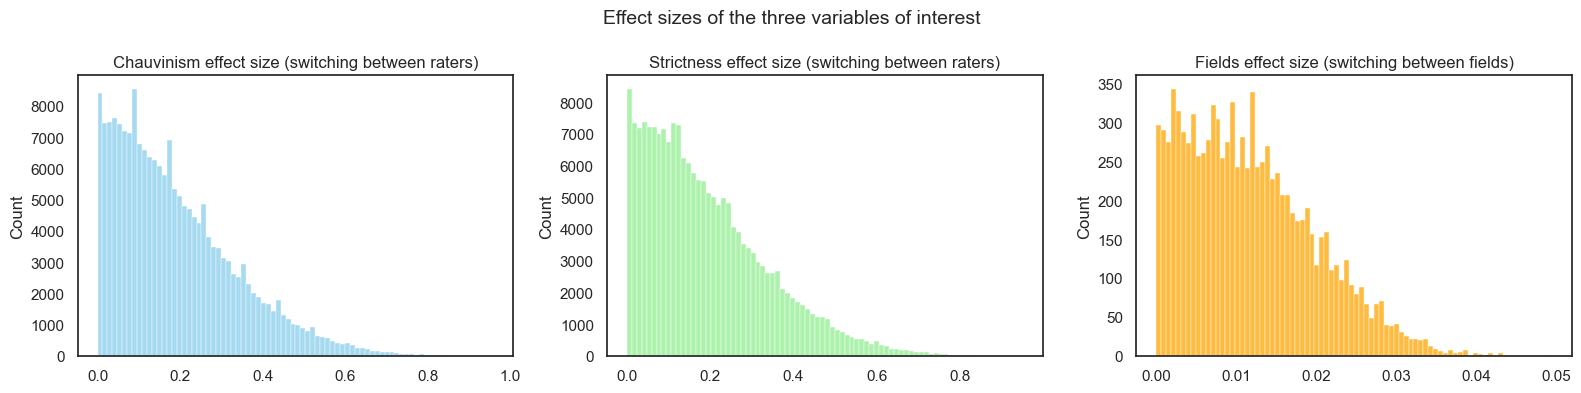

In [303]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (16,4), sharey = False, sharex = False)

sns.histplot(es_chauv,bins = 80,ax = ax[0], color = colors[0])
sns.histplot(es_strictness,bins = 80, ax = ax[1],color = colors[1]) 
sns.histplot(es_fields,bins = 80,ax = ax[2],color = colors[2]) 


ax[0].set_title(f'Chauvinism effect size (switching between raters)')
ax[1].set_title(f'Strictness effect size (switching between raters)')
ax[2].set_title(f'Fields effect size (switching between fields)')

plt.suptitle('Effect sizes of the three variables of interest', fontsize = 14)

fig.tight_layout()

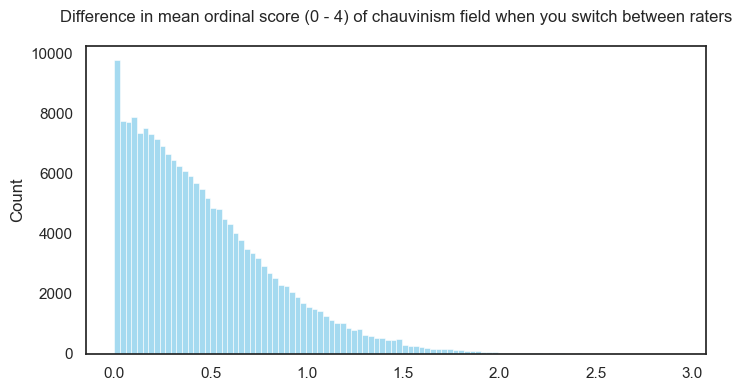

In [304]:
# for chauvinism, we can also plot the effect on rank scores of the field one is chauvinistic about

es_chauv_rank = []
# difference in average score
for i in chauvinism_rank_scores:
    for j in combinations(i,2):
        es_chauv_rank.append(abs(j[0]-j[1]))

fig, ax = plt.subplots(figsize = (8,4))
sns.histplot(np.array(es_chauv_rank),bins = 100,color = colors[0],ax=ax)
ax.set_title('Difference in mean ordinal score (0 - 4) of chauvinism field when you switch between raters', y = 1.05)
plt.show()

## Method 1.2: Compare the effect sizes of chauvinism, strictness and field

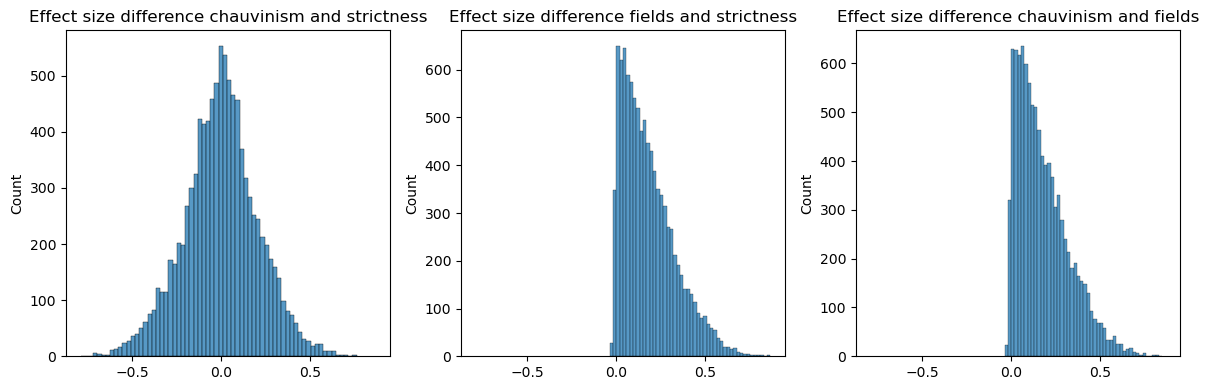

In [145]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4), sharey = False, sharex = True)

es_strictness_short = np.random.choice(es_strictness, len(es_fields), replace = True)
es_chauv_short = np.random.choice(es_chauv, len(es_fields), replace = True)

sns.histplot(es_chauv_short- es_strictness_short,ax = ax[0]) #, bw_adjust = 2
sns.histplot(es_strictness_short - np.array(es_fields) , ax = ax[1]) #, bw_adjust = 2
sns.histplot(es_chauv_short - np.array(es_fields),ax = ax[2]) #, bw_adjust = 2


ax[0].set_title(f'Effect size difference chauvinism and strictness')
ax[1].set_title(f'Effect size difference fields and strictness')
ax[2].set_title(f'Effect size difference chauvinism and fields')

fig.tight_layout()

# QUESTION 2: Differences between fields

We will at least report the top figure or ridgeplot, i.e. the one based on posterior predictive samples.

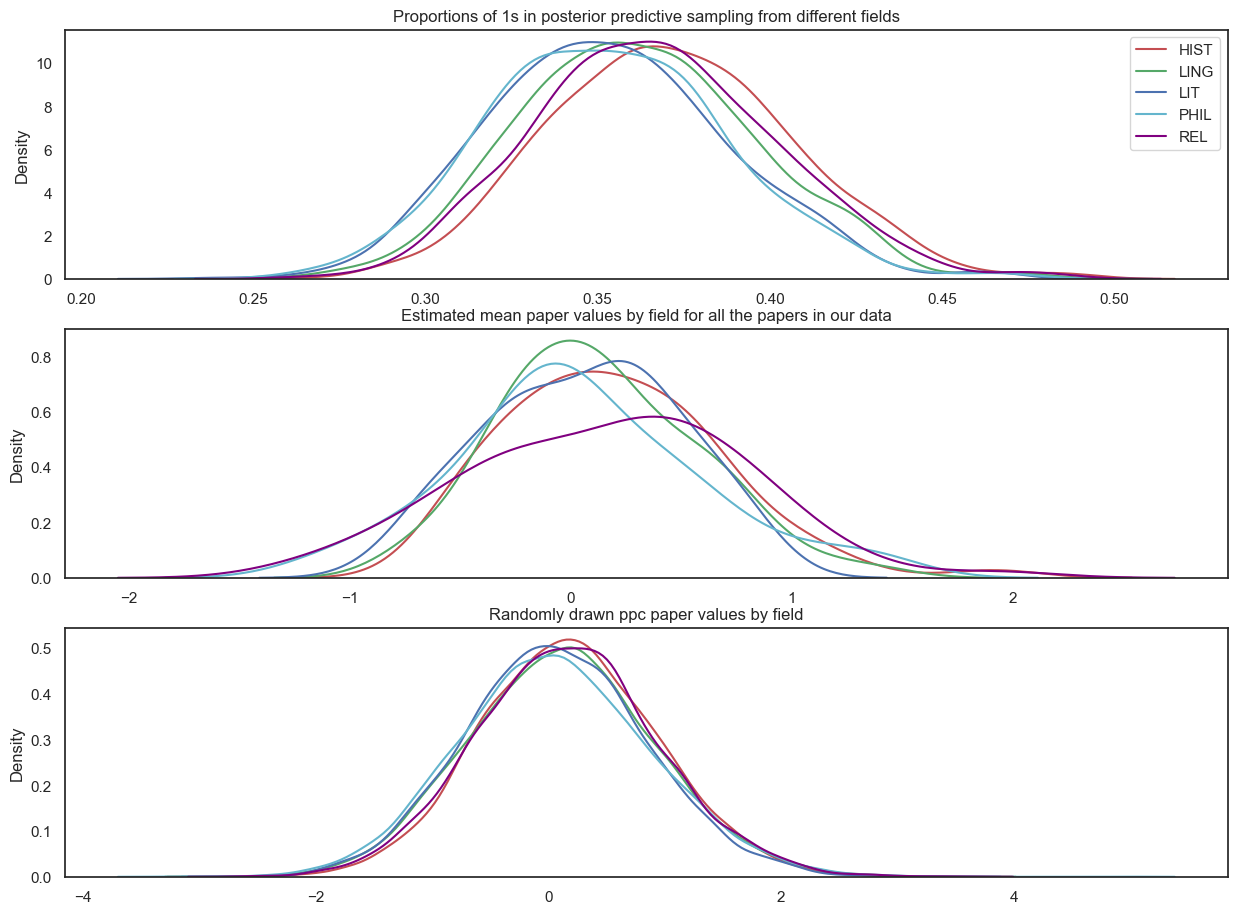

In [311]:
# plot the distribution of proportions of 1s for all fields

text = ['HIST',	'LING',	'LIT'	,'PHIL'	,'REL']
fig, ax = plt.subplots(nrows = 3, figsize = (15,11))

# get paper values by field from the ppc draws
ppc_paper_values = [np.random.choice(np.ravel(np.array(paper_values_dct[i])), 10000, replace = True) for i in field_names]


for i in range(5): 
    f = sns.kdeplot(list(trials.values())[i], color = colors[i], ax=ax[0])
    f2 = sns.kdeplot(ppc_paper_values[i], color = colors[i], ax=ax[2])
ax[0].legend(text)

# for comparison, also plot the distributions of mean estimated paper value by field. These are just the estimated values of the papers in our sample.
sns.set(style="dark")

for i in range(5):
    sns.kdeplot(trace_test.posterior['paper_values'][:,:,:,i].mean(dim = ['chain','draw']).values,color = colors[i], ax = ax[1])



ax[0].set_title('Proportions of 1s in posterior predictive sampling from different fields')
ax[1].set_title('Estimated mean paper values by field for all the papers in our data')
ax[2].set_title('Randomly drawn ppc paper values by field')
plt.show()

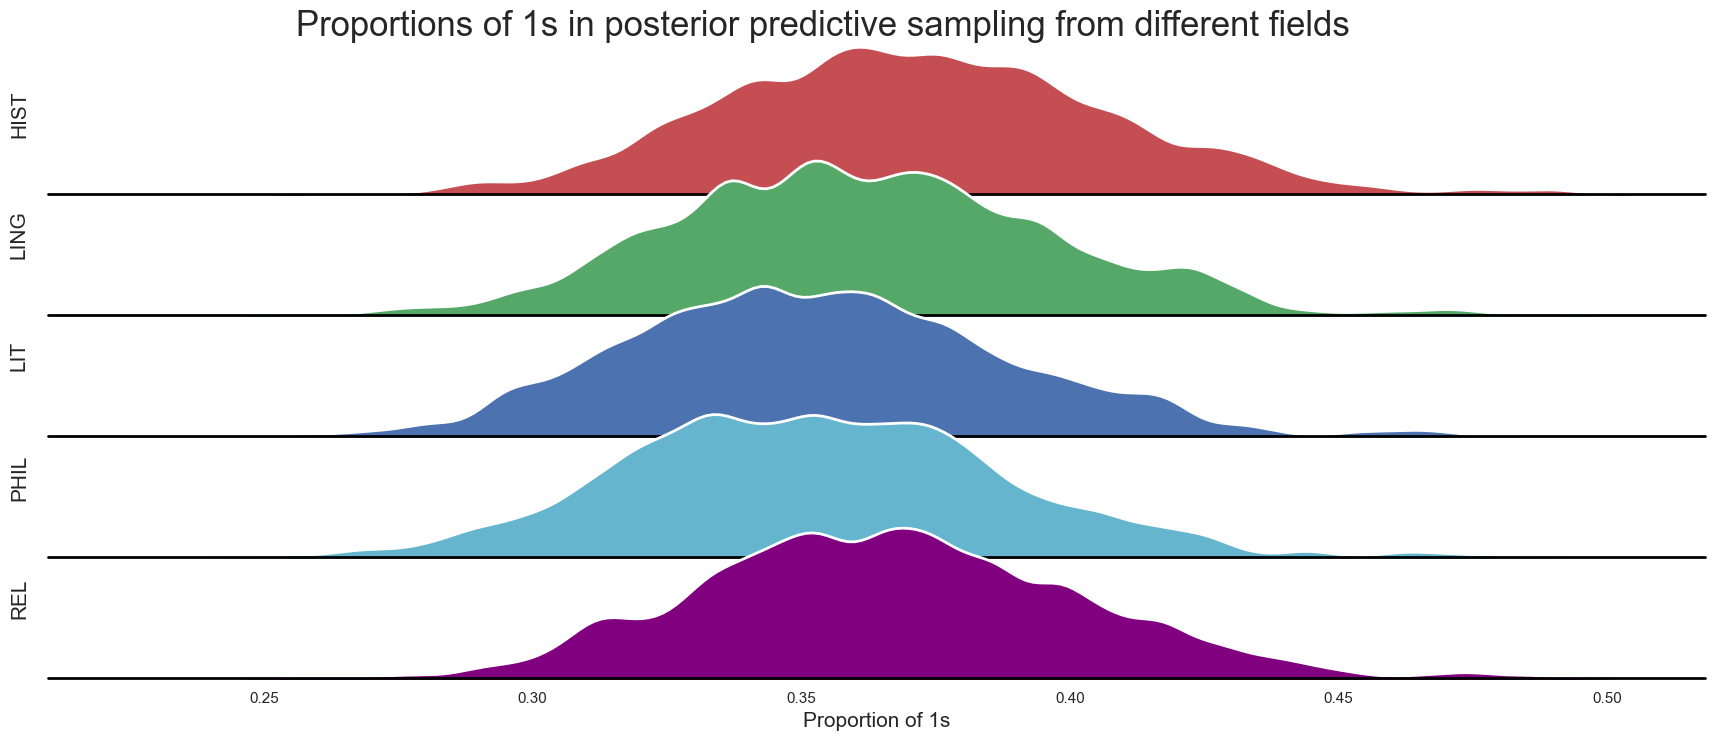

In [313]:
# plot the main figure also as a ridgeplot given that everything is overlapping here

from matplotlib.ticker import FixedLocator

# Ignore the specific UserWarnings related to tight_layout
warnings.filterwarnings('ignore', category=UserWarning)
# Convert dictionary to a long-form DataFrame for seaborn
df = pd.DataFrame(trials)
df = df.melt(var_name='Field', value_name='Effect Size')

# Create the ridge plot
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data for the ridge plot
g = sns.FacetGrid(df, row="Field", hue="Field", aspect=12, height=1.5, palette=colors)

# Map the density plots to each facet
g.map(sns.kdeplot, "Effect Size", clip_on=False, shade=True, alpha=1, lw=1.5, bw_adjust=0.5)
g.map(sns.kdeplot, "Effect Size", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Define a function to add a line for each level
def add_line(x, **kwargs):
    plt.axhline(y=x.name, color='black', lw=2, clip_on=False)

# Apply the function to each facet
g.map(add_line, "Effect Size")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-0.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set_xlabels("Proportion of 1s", fontsize = 15)
g.set_ylabels('')
ytick_positions = [0, 1, 2,3,4]
for ax, field in zip(g.axes.flat,field_names):
    ax.set_yticks([4])  # Each subplot has a single y-tick at position 0
    ax.set_ylabel(field, fontsize = 15)

g.despine(bottom=True, left=True)
plt.suptitle("Proportions of 1s in posterior predictive sampling from different fields", fontsize = 25)

# Show the plot
plt.show()


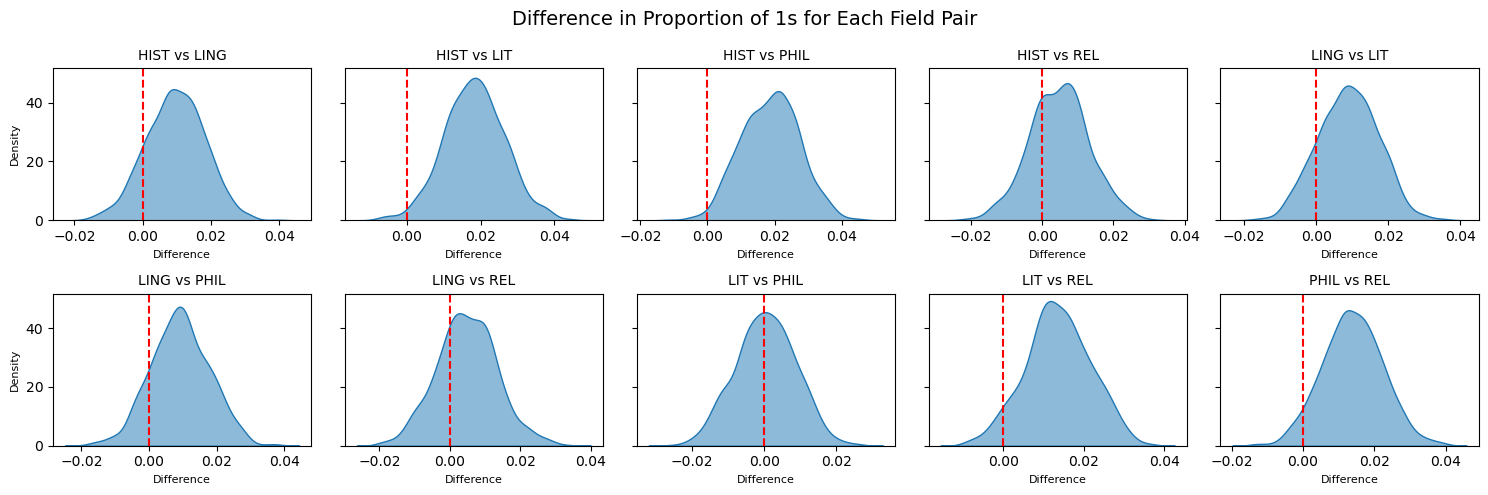

In [154]:
# plot the individual comparisons between fields

fig, axs = plt.subplots(2,5,figsize = (15,5), sharey=True)

for ax,i in zip(axs.flat, combinations(range(5),2)):
    
    # get the proportions of 1s in each of the ppc samples for each pair of fields
    field_a = np.array(trials[field_names[i[0]]])
    field_b = np.array(trials[field_names[i[1]]])
    
    # subtract the smaller from the larger
    # question: should we use mean here, or something else?
    
    if field_a.mean() > field_b.mean():
        dif = field_a - field_b
    else:
        dif = field_b - field_a
        
    # store and plot
    
    field_effect_sizes[f'dif_{i}'] = dif
    sns.kdeplot(dif, ax=ax, fill=True, alpha=0.5)

    ax.set_title(f'{field_names[i[0]]} vs {field_names[i[1]]}', fontsize=10)
    ax.axvline(0, color='r', linestyle='--')  # Use a dashed line for visual clarity
    ax.set_xlabel('Difference', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)

plt.suptitle('Difference in Proportion of 1s for Each Field Pair', fontsize=14)
fig.tight_layout()
plt.show()

# QUESTION 3: Are raters chauvinistic?

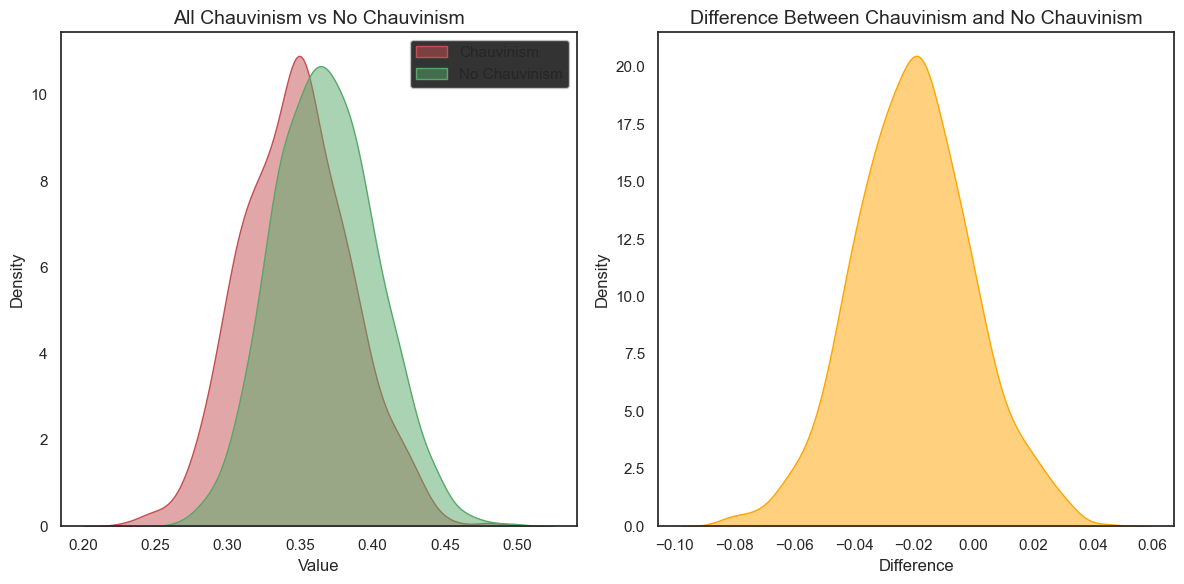

In [314]:

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
text = ['Chauvinism', 'No Chauvinism']
c = 0

for key, value in trials_chauv.items():
    f = sns.kdeplot(value, color=colors[c], ax=ax[0], fill=True, alpha=0.5)

    c += 1

ax[0].set_title('All Chauvinism vs No Chauvinism', fontsize=14)
ax[0].set_xlabel('Value', fontsize=12)
ax[0].set_ylabel('Density', fontsize=12)
ax[0].legend(text)
difference = np.array(list(trials_chauv.values())[0]) - np.array(list(trials_chauv.values())[1])
f2 = sns.kdeplot(difference, ax=ax[1], color='orange', fill=True, alpha=0.5)
ax[1].set_title('Difference Between Chauvinism and No Chauvinism', fontsize=14)
ax[1].set_xlabel('Difference', fontsize=12)
ax[1].set_ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()

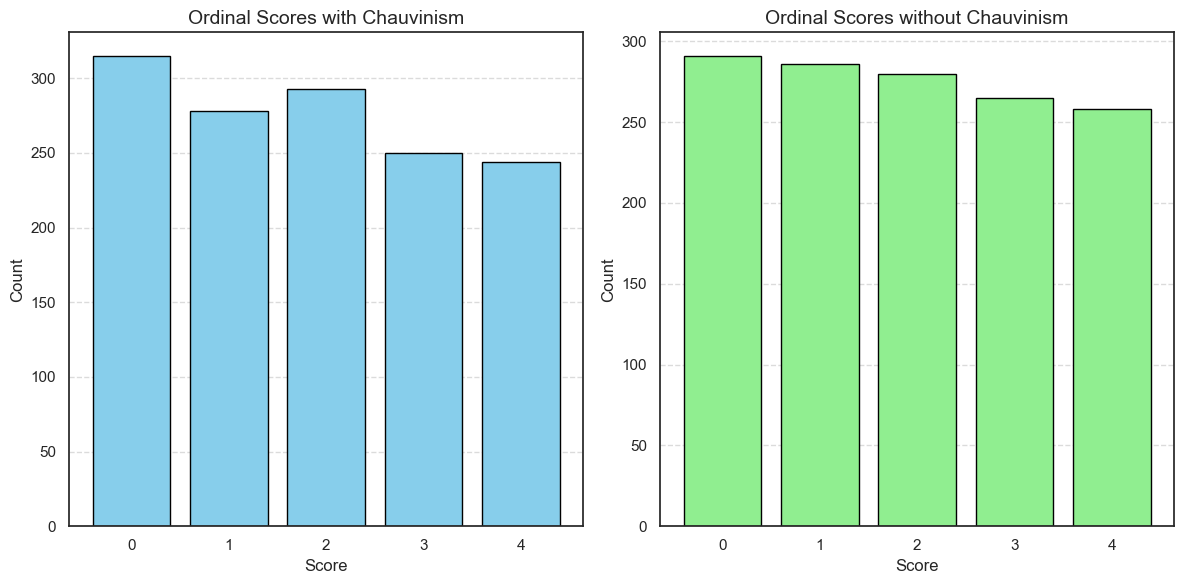

In [315]:
# plot the effect on ranking of switching on and off chauvinism

# Calculate counts of each score
scores = np.arange(5)  # Scores from 0 to 4
chauv_counts = [np.sum((np.argsort(chauv_reshaped).reshape(new_J * int(n_ppc / 5), K))[:,0] == score) for score in scores]
no_chauv_counts = [np.sum((np.argsort(no_chauv_reshaped).reshape(new_J * int(n_ppc / 5), K))[:,0] == score) for score in scores]

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

# Bar chart for the chauvinism field
ax[0].bar(scores, chauv_counts, color='skyblue', edgecolor='black')
ax[0].set_title('Ordinal Scores with Chauvinism', fontsize=14)
ax[0].set_xlabel('Score', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_xticks(scores)
ax[0].set_xticklabels(['0', '1', '2', '3', '4'])
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# Bar chart for the same field without chauvinism
ax[1].bar(scores, no_chauv_counts, color='lightgreen', edgecolor='black')
ax[1].set_title('Ordinal Scores without Chauvinism', fontsize=14)
ax[1].set_xlabel('Score', fontsize=12)
ax[1].set_ylabel('Count', fontsize=12)
ax[1].set_xticks(scores)
ax[1].set_xticklabels(['0', '1', '2', '3', '4'])
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# QUESTION 4: Aggregate judgement of societal relevance

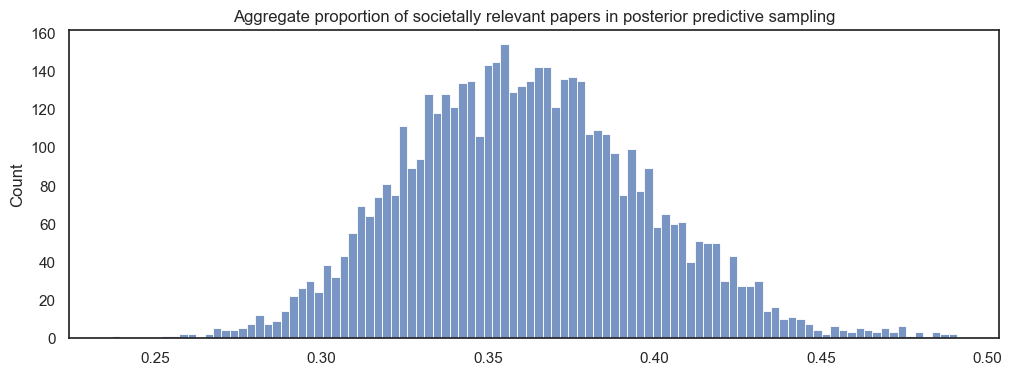

In [316]:
# we do N number of trials, each time with different reviewers, and record what proportion of 1s we get.
fig, ax = plt.subplots(figsize = (12,4))
sns.histplot(np.ravel(np.array([i for i in trials.values()])), bins = 100,ax=ax)
ax.set_title('Aggregate proportion of societally relevant papers in posterior predictive sampling')

plt.show()